## This Notebook Demonstrates the working of text to image generation using GAN (Generative Adversarial Networks)

#### The following project requires a series of dataset to be downloaded from multiple sources. These include:

1. Image Description : https://drive.google.com/file/d/0B0ywwgffWnLLcms2WWJQRFNSWXM/view
2.Images: https://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html
3.Image Caption: https://drive.google.com/file/d/0B0ywwgffWnLLcms2WWJQRFNSWXM/view
(Based on : https://github.com/zsdonghao/text-to-image)
4. Glove Embeddings: https://nlp.stanford.edu/projects/glove/
The image descriptions were processed into character level embeddings using the 300 D GloVe embeddings 


#### ***However, these have already been consolidated for you in the following link***:
https://drive.google.com/file/d/165hQy9jippA46ZJNbV_X_8dUWM5wGhA5/view?usp=share_link

(Note: This will be performed in step 5 below)
Download the zip file upload the unzipped contents of the zip into your drive location (My Drive/Projects) 

In [1]:
# 1

# Necessary imports
import glob
import pandas as pd
import urllib.request
import imageio
import os
import numpy as np
import gdown
import requests

from urllib.request import urlopen

The following packages will be used to implement a basic GAN system in Python/Keras.

In [2]:
# 2

# Imports
import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense, Concatenate 
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras import initializers
from sklearn.metrics import mean_squared_error

import numpy as np
from PIL import Image
from tqdm import tqdm
import os 
import time
import matplotlib.pyplot as plt


In [ ]:
# 3
# This library is used to download files/folders from a Google Drive
# drive files: https://drive.google.com/file/d/165hQy9jippA46ZJNbV_X_8dUWM5wGhA5/view?usp=share_link

!pip install gdown -U --no-cache-dir
import gdown

key ='165hQy9jippA46ZJNbV_X_8dUWM5wGhA5'
url = 'https://drive.google.com/uc?id=' + key
out_path = 'Project.zip'
zipfile = gdown.download(url, out_path, quiet=False)
!unzip 'Project.zip'

In [4]:
# 4

# Setting up the paths

# drive_path = '/content/drive/MyDrive/'
drive_path = ''
train_data_path = drive_path + "Project/flowers_data/flowers"
train_images_path = drive_path +"Project/flowers_data/flowers/images/jpg"
train_captions_path = drive_path +"Project/flowers_data/flowers/text_c10"

In [5]:
# 5

# Load Glove Function
def loadGloveModel(gloveFile):
    print("Loading Glove Model")
    f = open(gloveFile,'r',encoding="utf8")
    model = {}
    for line in f:
        try:
            splitLine = line.split()
            word = splitLine[0]
            embedding = np.array([float(val) for val in splitLine[1:]])
            model[word] = embedding
        except:
            print(word)
    print("Done.",len(model)," words loaded!")
    return model

glove_embeddings = loadGloveModel(drive_path +"Project/face_gan/embeddings/glove.6B.300d.txt")

Loading Glove Model
Done. 400000  words loaded!


In [6]:
# 6

# Formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

In [8]:
# 7

# Generation resolution - Must be square 
# Training data is also scaled to this.
GENERATE_RES = 2 # Generation resolution factor 
# (1=32, 2=64, 3=96, 4=128, etc.)
GENERAT_SQUARE = 32 * GENERATE_RES # rows/cols (should be square)
IMAGE_CHANNELS = 3

# Preview image 
PREVIEW_ROWS = 4
PREVIEW_COLS = 7
PREVIEW_MARGIN = 16

# Size vector to generate images from
SEED_SIZE = 100
EMBEDDING_SIZE = 300

# Configuration
DATA_PATH = train_images_path
MODEL_PATH = drive_path +"Project/flowers_data/flowers/model"
EPOCHS = 150
BATCH_SIZE = 64
BUFFER_SIZE = 4000

print(f"Will generate {GENERATE_SQUARE}px square images.")

Will generate 64px square images.


## Data Pre-Processing 

Next we will load and preprocess the images.  This can take awhile.  Google CoLab took around an hour to process.  Because of this we store the processed file as a binary.  This way we can simply reload the processed training data and quickly use it.  It is most efficient to only perform this operation once.  The dimensions of the image are encoded into the filename of the binary file because we need to regenerate it if these change.

In [ ]:
# 8

# Image set has 8,188 images.  Can take over an hour 
# for initial preprocessing.
# Because of this time needed, save a Numpy preprocessed file.

training_binary_path = os.path.join(drive_path +"Project/flowers_data/flowers/images/npy64",
        f'training_data_{GENERATE_SQUARE}_{GENERATE_SQUARE}_')

start = time.time()
print("Loading training images...")

training_data = []
flowers_path = sorted(os.listdir(DATA_PATH))

for filename in range(len(flowers_path)):
    path = os.path.join(DATA_PATH,flowers_path[filename])
    # print(path)
    try:
      image = Image.open(path).resize((GENERATE_SQUARE,
            GENERATE_SQUARE),Image.ANTIALIAS)
      channel = np.asarray(image).shape[2]
      if channel == 3:
        training_data.append(np.asarray(image))
    except KeyboardInterrupt:
        print("Keyboard Interrup by me...")
        break
    except:
      pass
    if len(training_data) == 100:
      training_data = np.reshape(training_data,(-1,GENERATE_SQUARE,
                GENERATE_SQUARE,IMAGE_CHANNELS))
      training_data = training_data.astype(np.float32)
      #Normalizing the input
      training_data = training_data / 127.5 - 1.

      print("Saving training image " + str(100000 + filename) + ".npy")
      np.save(training_binary_path + str(100000 + filename) + ".npy",training_data)
      elapsed = time.time()-start
      print (f'Image preprocess time: {hms_string(elapsed)}')
      training_data = []
print("Complete")

Loading training images...


/var/folders/jx/rkmwv0193mbgyy9qhk2gc2qw0000gn/T/ipykernel_19278/1763248941.py:19: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  GENERATE_SQUARE),Image.ANTIALIAS)


Saving training image 100099.npy
Image preprocess time: 0:00:00.80
Saving training image 100199.npy
Image preprocess time: 0:00:01.56
Saving training image 100299.npy
Image preprocess time: 0:00:02.32
Saving training image 100399.npy
Image preprocess time: 0:00:03.06
Saving training image 100499.npy
Image preprocess time: 0:00:03.79
Saving training image 100599.npy
Image preprocess time: 0:00:04.49
Saving training image 100699.npy
Image preprocess time: 0:00:05.21
Saving training image 100799.npy
Image preprocess time: 0:00:05.93
Saving training image 100899.npy
Image preprocess time: 0:00:06.64
Saving training image 100999.npy
Image preprocess time: 0:00:07.38
Saving training image 101099.npy
Image preprocess time: 0:00:08.18
Saving training image 101199.npy
Image preprocess time: 0:00:08.93
Saving training image 101299.npy
Image preprocess time: 0:00:09.65
Saving training image 101399.npy
Image preprocess time: 0:00:10.40
Saving training image 101499.npy
Image preprocess time: 0:00:1

Next we will load and preprocess the captions. This can take awhile. Google CoLab took around an hour to process. Because of this we store the processed file as a binary. This way we can simply reload the processed data and quickly use it. It is most efficient to only perform this operation once.

In [ ]:
# 9

text_path = drive_path + "Project/flowers_data/flowers/text_c10/captions"
text_files = sorted(os.listdir(text_path))
captions = []
caption_embeddings = np.zeros((len(text_files),300),dtype=np.float32)
for filename in range(len(text_files)):
    path = os.path.join(text_path,text_files[filename])
    # print(path)
    f = open(path,'r')
    data = f.read()
    data = data.split("\n")
    f.close()
    for d in range(1):
      x = data[d].lower()
      x = x.replace("-"," ")
      captions.append(x)
      count = 0
      for t in x:
        try:
          caption_embeddings[filename] += glove_embeddings[t]
          count += 1
        except:
          print(t)
          pass
      caption_embeddings[filename] /= count
    if filename %100 == 0:
      print("-------------Files completed:",filename)

 
 
 
 
 
 
-------------Files completed: 0
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 


 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
-------------Files completed: 1500
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 

 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
-------------Files completed: 3200
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 

In [ ]:
# 10

# saving the caption embeddings numpy
embedding_binary_path = os.path.join(drive_path+'Project/flowers_data/flowers/images/embedding_npy',
        f'embedding_data.npy')
print("Saving captions embeddings binary...")
np.save(embedding_binary_path,caption_embeddings)

Saving captions embeddings binary...


In [ ]:
# 11
print(len(captions))
print(captions[:10])

['prominent purple stigma,petals are white inc olor',
 'this flower is blue and green in color, with petals that are oval shaped.',
 'outer petals are green in color and klarger,inner petals are needle shaped',
 'there are several shapes, sizes, and colors of petals on this complex flower.',
 'the stamen are towering over the stigma which cannot be seen.',
 'this flower is white and purple in color, with petals that are oval shaped.',
 'the petals of this flower are green with a long stigma',
 'the blossom has a layer of rounded purple and white petals topped by a layer of fringed purple petals.',
 'this flower is purple and yellow in color, with petals that are oval shaped.',
 'the petals on this flower are white with an elaborate pistil.']

## Loading and combining numpys

In [ ]:
# 12

embedding_binary_path = os.path.join(drive_path+'Project/flowers_data/flowers/images/embedding_npy',
        f'embedding_data.npy')
caption_embeddings = np.load(embedding_binary_path)
# caption_embeddings = caption_embeddings[::5]
caption_embeddings.shape

In [ ]:
# 13

image_binary_path = drive_path+"Project/flowers_data/flowers/images/npy64/"
images = os.listdir(image_binary_path)
print("final file:",images[-1])

# Creating a list of all the preprocessed images
final_images = np.load(image_binary_path + images[0])
for i in images[1:]:
  print(i)
  try:
    final_images = np.concatenate([final_images,np.load(image_binary_path + i)],axis = 0)
  except:
    pass

print("image shape:",final_images.shape)

training_data_64_64_107499.npy
training_data_64_64_103199.npy
training_data_64_64_105099.npy
training_data_64_64_101599.npy
training_data_64_64_102899.npy
training_data_64_64_105299.npy
training_data_64_64_101799.npy
training_data_64_64_107699.npy
training_data_64_64_103399.npy
training_data_64_64_107299.npy
training_data_64_64_103799.npy
training_data_64_64_105699.npy
training_data_64_64_101399.npy
training_data_64_64_105499.npy
training_data_64_64_101199.npy
training_data_64_64_106999.npy
training_data_64_64_100899.npy
training_data_64_64_107099.npy
training_data_64_64_103599.npy
training_data_64_64_101699.npy
training_data_64_64_105399.npy
training_data_64_64_103299.npy
training_data_64_64_107799.npy
training_data_64_64_103099.npy
training_data_64_64_107599.npy
training_data_64_64_104899.npy
training_data_64_64_102999.npy
training_data_64_64_101499.npy
training_data_64_64_105199.npy
training_data_64_64_106899.npy
training_data_64_64_101099.npy
training_data_64_64_105599.npy
training

In [ ]:
# 14

# Creating a dataframe to store the captions
df_captions = pd.DataFrame([])
df_captions['captions'] = captions[:len(final_images)]
df_captions.to_csv(drive_path + "Project/flowers_data/flowers/text_c10/captions.csv",index=None)
print(df_captions.head())

df_captions = pd.read_csv(drive_path + "Project/flowers_data/flowers/text_c10/captions.csv")
print(df_captions.head())

caption_embeddings = caption_embeddings[:final_images.shape[0]]
caption_embeddings.shape

,captions
0,"prominent purple stigma,petals are white inc olor"
1,"this flower is blue and green in color, with p..."
2,"outer petals are green in color and klarger,in..."
3,"there are several shapes, sizes, and colors of..."
4,the stamen are towering over the stigma which ...


Saved images separately for testing

In [ ]:
# 15

save_images_captions = captions[:28].copy()
save_images_embeddings = np.copy(caption_embeddings[:28])
save_images_npy = np.copy(final_images[:28])

Shuffling the data

In [ ]:
# 16
p = np.random.permutation(len(final_images))
final_images_shuffled = final_images[p]
final_embeddings_shuffled = caption_embeddings[p]

final_images_shuffled.shape, final_embeddings_shuffled.shape

(8100, 64, 64, 3)

In [ ]:
# 17

# Batch and shuffle the data
# train_dataset = tf.data.Dataset.from_tensor_slices(training_data) \
#     .shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset = tf.data.Dataset.from_tensor_slices({'images': final_images,
                                                    'embeddings': caption_embeddings}).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

Metal device set to: Apple M2


2022-12-14 03:39:51.911968: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-14 03:39:51.912295: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Data Modeling

Defining the Generator and Discriminator

In [ ]:
# 18

def build_generator_func(seed_size,embedding_size, channels):
  input_seed = Input(shape=seed_size)
  input_embed = Input(shape = embedding_size)
  d0 = Dense(128)(input_embed)
  leaky0 = LeakyReLU(alpha=0.2)(d0)

  merge = Concatenate()([input_seed, leaky0])

  d1 = Dense(4*4*256,activation="relu")(merge)
  reshape = Reshape((4,4,256))(d1)

  upSamp1 = UpSampling2D()(reshape)
  conv2d1 = Conv2DTranspose(256,kernel_size=5,padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(upSamp1)
  batchNorm1 = BatchNormalization(momentum=0.8)(conv2d1)
  leaky1 = LeakyReLU(alpha=0.2)(batchNorm1)

  upSamp2 = UpSampling2D()(leaky1)
  conv2d2 = Conv2DTranspose(256,kernel_size=5,padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(upSamp2)
  batchNorm2 = BatchNormalization(momentum=0.8)(conv2d2)
  leaky2 = LeakyReLU(alpha=0.2)(batchNorm2)

  upSamp3 = UpSampling2D()(leaky2)
  conv2d3 = Conv2DTranspose(128,kernel_size=4,padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(upSamp3)
  batchNorm3 = BatchNormalization(momentum=0.8)(conv2d3)
  leaky3 = LeakyReLU(alpha=0.2)(batchNorm3)

  upSamp4 = UpSampling2D(size=(GENERATE_RES,GENERATE_RES))(leaky3)
  conv2d4 = Conv2DTranspose(128,kernel_size=4,padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(upSamp4)
  batchNorm4 = BatchNormalization(momentum=0.8)(conv2d4)
  leaky4 = LeakyReLU(alpha=0.2)(batchNorm4)

  outputConv = Conv2DTranspose(channels,kernel_size=3,padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(leaky4)
  outputActi = Activation("tanh")(outputConv)

  model = Model(inputs=[input_seed,input_embed], outputs=outputActi)
  return model


In [ ]:
# 19

def build_discriminator_func(image_shape, embedding_size):
  input_shape = Input(shape=image_shape)
  input_embed = Input(shape=embedding_size)

  conv2d1 = Conv2D(32,kernel_size=4,strides=2,input_shape=image_shape,padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(input_shape)
  leaky1 = LeakyReLU(alpha=0.2)(conv2d1)

  drop2 = Dropout(0.25)(leaky1)
  conv2d2 = Conv2D(64, kernel_size=4, strides=2, padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(drop2)
  # zero2 = ZeroPadding2D(padding=((0,1),(0,1)))(conv2d2)
  batchNorm2 = BatchNormalization(momentum=0.8)(conv2d2)
  leaky2 = LeakyReLU(alpha=0.2)(batchNorm2)

  drop3 = Dropout(0.25)(leaky2)
  conv2d3 = Conv2D(128, kernel_size=4, strides=2, padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(drop3)
  batchNorm3 = BatchNormalization(momentum=0.8)(conv2d3)
  leaky3 = LeakyReLU(alpha=0.2)(batchNorm3)

  drop4 = Dropout(0.25)(leaky3)
  conv2d4 = Conv2D(256, kernel_size=4, strides=2, padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(drop4)
  batchNorm4 = BatchNormalization(momentum=0.8)(conv2d4)
  leaky4 = LeakyReLU(alpha=0.2)(batchNorm4)

  dense_embed = Dense(128,kernel_initializer=initializers.RandomNormal(stddev=0.02))(input_embed)
  leaky_embed = LeakyReLU(alpha=0.2)(dense_embed)
  reshape_embed = Reshape((4,4,8))(leaky_embed)
  merge_embed = Concatenate()([leaky4, reshape_embed])

  drop5 = Dropout(0.25)(merge_embed)
  conv2d5 = Conv2D(512, kernel_size=4,kernel_initializer=initializers.RandomNormal(stddev=0.02))(drop5)
  batchNorm5 = BatchNormalization(momentum=0.8)(conv2d5)
  leaky5 = LeakyReLU(alpha=0.2)(batchNorm5)

  drop6 = Dropout(0.25)(leaky5)
  flatten = Flatten()(drop6)
  output = Dense(1,activation="sigmoid")(flatten)

  model = Model(inputs=[input_shape,input_embed], outputs=output)
  return model

Function to save image samples generated

In [ ]:
# 20

def save_images(cnt,noise,embeds):
  image_array = np.full(( 
      PREVIEW_MARGIN + (PREVIEW_ROWS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 
      PREVIEW_MARGIN + (PREVIEW_COLS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 3), 
      255, dtype=np.uint8)

  generated_images = generator.predict((noise,embeds))

  generated_images = 0.5 * generated_images + 0.5

  image_count = 0
  for row in range(PREVIEW_ROWS):
      for col in range(PREVIEW_COLS):
        r = row * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        c = col * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        image_array[r:r+GENERATE_SQUARE,c:c+GENERATE_SQUARE] \
            = generated_images[image_count] * 255
        image_count += 1

          
  output_path = drive_path +"Project/flowers_data/flowers/output_64_character_extended"
  if not os.path.exists(output_path):
    os.makedirs(output_path)

  filename = os.path.join(output_path,f"train-{cnt}.png")
  im = Image.fromarray(image_array)
  im.save(filename)

In [ ]:
# 21

# Initlializing a generator
generator = build_generator_func(SEED_SIZE,EMBEDDING_SIZE, IMAGE_CHANNELS)
generator.load_weights(drive_path +"Project/flowers_data/flowers/model/text_to_image_generator_cub_character.h5")

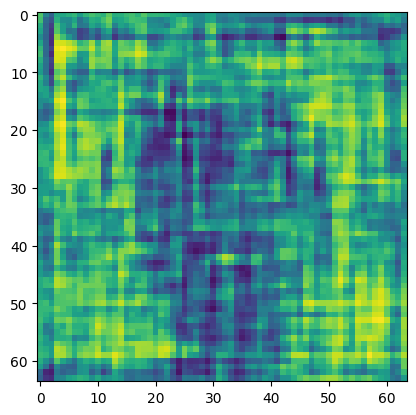

In [ ]:
# 22

# Sample output from the Generator
noise = tf.random.normal([1, 100])
generated_image = generator((noise,caption_embeddings[5].reshape(1,300)), training=False)

plt.imshow(generated_image[0, :, :, 0])

In [ ]:
# 23

# Initlializing a discriminator
image_shape = (GENERATE_SQUARE,GENERATE_SQUARE,IMAGE_CHANNELS)

discriminator = build_discriminator_func(image_shape,EMBEDDING_SIZE)
discriminator.load_weights((os.path.join(MODEL_PATH,"text_to_image_disc_cub_character.h5")))

In [ ]:
# 24

decision = discriminator((generated_image,caption_embeddings[5].reshape(1,300)))
print(decision)

tf.Tensor([[0.5704535]], shape=(1, 1), dtype=float32)


In [ ]:
# 25

# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_image_real_text, fake_image_real_text, real_image_fake_text):
    real_loss = cross_entropy(tf.random.uniform(real_image_real_text.shape,0.8,1.0), real_image_real_text)
    fake_loss = (cross_entropy(tf.random.uniform(fake_image_real_text.shape,0.0,0.2), fake_image_real_text) + 
                 cross_entropy(tf.random.uniform(real_image_fake_text.shape,0.0,0.2), real_image_fake_text))/2

    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

Both the generator and discriminator use Adam and the same learning rate and momentum.  This does not need to be the case.  If you use a **GENERATE_RES** greater than 3 you may need to tune these learning rates, as well as other training and hyperparameters.  

In [ ]:
# 26

# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=2e-4,
#     decay_steps=100,
#     decay_rate=0.5)
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=2.0e-4,beta_1 = 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=2.0e-4,beta_1 = 0.5)

## Training

In [ ]:
# 27

# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images,captions,fake_captions):
  seed = tf.random.normal([BATCH_SIZE, SEED_SIZE],dtype=tf.float32)

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator((seed,captions), training=True)
    real_image_real_text = discriminator((images,captions), training=True)
    real_image_fake_text = discriminator((images,fake_captions), training=True)
    fake_image_real_text = discriminator((generated_images,captions), training=True)

    gen_loss = generator_loss(fake_image_real_text)
    disc_loss = discriminator_loss(real_image_real_text, fake_image_real_text, real_image_fake_text)
    # print(gen_loss)
    # print(disc_loss)

    gradients_of_generator = gen_tape.gradient(\
        gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(\
        disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(
        gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(
        gradients_of_discriminator, 
        discriminator.trainable_variables))
  return gen_loss,disc_loss

In [ ]:
# 28

# Function that executes trianing process
def train(train_dataset, epochs):
  fixed_seed = np.random.normal(0, 1, (PREVIEW_ROWS * PREVIEW_COLS, 
                                       SEED_SIZE))
  fixed_embed = save_images_embeddings

  start = time.time()

  for epoch in range(epochs):
    print("epoch start...")
    epoch_start = time.time()

    gen_loss_list = []
    disc_loss_list = []

    for batch in train_dataset[:-1]:
      # train_batch = training_data[BATCH_SIZE*image_batch : BATCH_SIZE*image_batch + BATCH_SIZE]
      # caption_batch = captions[BATCH_SIZE*image_batch : BATCH_SIZE*image_batch + BATCH_SIZE]
      train_batch = batch['images']
      caption_batch = batch['embeddings']
      
      fake_caption_batch = np.copy(caption_batch)
      np.random.shuffle(fake_caption_batch)
      
      t = train_step(train_batch,caption_batch,fake_caption_batch)
      # print(t)
      gen_loss_list.append(t[0])
      disc_loss_list.append(t[1])
      # if image_batch%50 == 0:
      #   print(image_batch)
      # print("here")
    print("now")
    g_loss = sum(gen_loss_list) / len(gen_loss_list)
    d_loss = sum(disc_loss_list) / len(disc_loss_list)

    epoch_elapsed = time.time()-epoch_start
    print(f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss}, {hms_string(epoch_elapsed)}')
    save_images(epoch,fixed_seed,fixed_embed)
    
    generator.save(os.path.join(MODEL_PATH,"text_to_image_generator_cub_character.h5"))
    discriminator.save(os.path.join(MODEL_PATH,"text_to_image_disc_cub_character.h5"))
    print("model saved")

  elapsed = time.time()-start
  print ('Training time:', hms_string(elapsed))


In [ ]:
# 29

tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

In [ ]:
# 30

train(list(train_dataset.as_numpy_iterator()), EPOCHS)

epoch start...
now
Epoch 1, gen loss=0.6840439438819885,disc loss=1.3826639652252197, 0:02:23.52


2022-12-14 03:43:23.534754: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1/1 [==============================] - 0s 277ms/step
model saved
epoch start...
now
Epoch 2, gen loss=0.7174360156059265,disc loss=1.3731563091278076, 0:03:16.69
1/1 [==============================] - 0s 123ms/step
model saved
epoch start...
now
Epoch 3, gen loss=0.7283430695533752,disc loss=1.369661569595337, 0:03:33.44
1/1 [==============================] - 0s 123ms/step
model saved
epoch start...
now
Epoch 4, gen loss=0.7692717909812927,disc loss=1.3580204248428345, 0:03:37.77
1/1 [==============================] - 0s 124ms/step
model saved
epoch start...
now
Epoch 5, gen loss=0.7147719264030457,disc loss=1.3728699684143066, 0:03:44.26
1/1 [==============================] - 0s 127ms/step
model saved
epoch start...
now
Epoch 6, gen loss=0.730857253074646,disc loss=1.3693222999572754, 0:05:52.56
1/1 [==============================] - 0s 109ms/step
model saved
epoch start...
now
Epoch 7, gen loss=0.7642326354980469,disc loss=1.3549913167953491, 0:03:51.04
1/1 [=========================

model saved
epoch start...
now
Epoch 18, gen loss=0.7012928128242493,disc loss=1.3760650157928467, 0:03:08.53
1/1 [==============================] - 0s 115ms/step
model saved
epoch start...
now
Epoch 19, gen loss=0.7036849856376648,disc loss=1.3736878633499146, 0:03:05.24
1/1 [==============================] - 0s 118ms/step
model saved
epoch start...
now
Epoch 20, gen loss=0.7041129469871521,disc loss=1.374448299407959, 0:03:05.97
1/1 [==============================] - 0s 117ms/step
model saved
epoch start...
now
Epoch 21, gen loss=0.7126197814941406,disc loss=1.3713322877883911, 0:03:06.00
1/1 [==============================] - 0s 116ms/step
model saved
epoch start...
now
Epoch 22, gen loss=0.7168050408363342,disc loss=1.3693722486495972, 0:03:02.66
1/1 [==============================] - 0s 115ms/step
model saved
epoch start...
now
Epoch 23, gen loss=0.7226899266242981,disc loss=1.368366003036499, 0:03:01.95
1/1 [==============================] - 0s 119ms/step
model saved
epoch start.

model saved
epoch start...
now
Epoch 34, gen loss=0.724392831325531,disc loss=1.3691625595092773, 0:02:56.54
1/1 [==============================] - 0s 114ms/step
model saved
epoch start...
now
Epoch 35, gen loss=0.7230345606803894,disc loss=1.368370771408081, 0:02:57.25
1/1 [==============================] - 0s 116ms/step
model saved
epoch start...
now
Epoch 36, gen loss=0.7207648158073425,disc loss=1.369284749031067, 0:02:56.85
1/1 [==============================] - 0s 115ms/step
model saved
epoch start...
now
Epoch 37, gen loss=0.7343468070030212,disc loss=1.3648085594177246, 0:02:57.18
1/1 [==============================] - 0s 79ms/step
model saved
epoch start...
now
Epoch 38, gen loss=0.74488765001297,disc loss=1.3596763610839844, 0:02:56.51
1/1 [==============================] - 0s 113ms/step
model saved
epoch start...
now
Epoch 39, gen loss=0.7454970479011536,disc loss=1.3611583709716797, 0:02:55.99
1/1 [==============================] - 0s 120ms/step
model saved
epoch start...
n

model saved
epoch start...
now
Epoch 51, gen loss=0.7454988956451416,disc loss=1.3590989112854004, 0:02:52.83
1/1 [==============================] - 0s 112ms/step
model saved
epoch start...
now
Epoch 52, gen loss=0.7541791796684265,disc loss=1.357496738433838, 0:02:52.67
1/1 [==============================] - 0s 112ms/step
model saved
epoch start...
now
Epoch 53, gen loss=0.7625499367713928,disc loss=1.353925347328186, 0:02:52.33
1/1 [==============================] - 0s 114ms/step
model saved
epoch start...
now
Epoch 54, gen loss=0.7573001980781555,disc loss=1.357414960861206, 0:02:52.90
1/1 [==============================] - 0s 79ms/step
model saved
epoch start...
now
Epoch 55, gen loss=0.7618250846862793,disc loss=1.3548003435134888, 0:02:52.55
1/1 [==============================] - 0s 113ms/step
model saved
epoch start...
now
Epoch 56, gen loss=0.7563826441764832,disc loss=1.3574596643447876, 0:02:51.66
1/1 [==============================] - 0s 79ms/step
model saved
epoch start...


model saved
epoch start...
now
Epoch 67, gen loss=0.7908190488815308,disc loss=1.3455240726470947, 0:02:51.65
1/1 [==============================] - 0s 116ms/step
model saved
epoch start...
now
Epoch 68, gen loss=0.7968060970306396,disc loss=1.3439922332763672, 0:02:51.54
1/1 [==============================] - 0s 111ms/step
model saved
epoch start...
now
Epoch 69, gen loss=0.7953845262527466,disc loss=1.3424185514450073, 0:02:50.89
1/1 [==============================] - 0s 110ms/step
model saved
epoch start...
now
Epoch 70, gen loss=0.8016142249107361,disc loss=1.3425488471984863, 0:02:49.57
1/1 [==============================] - 0s 111ms/step
model saved
epoch start...
now
Epoch 71, gen loss=0.798957347869873,disc loss=1.3433576822280884, 0:02:49.36
1/1 [==============================] - 0s 112ms/step
model saved
epoch start...
now
Epoch 72, gen loss=0.8101714849472046,disc loss=1.3391048908233643, 0:02:50.15
1/1 [==============================] - 0s 116ms/step
model saved
epoch start

model saved
epoch start...
now
Epoch 83, gen loss=0.8467865586280823,disc loss=1.3219274282455444, 0:02:52.91
1/1 [==============================] - 0s 113ms/step
model saved
epoch start...
now
Epoch 84, gen loss=0.8579093217849731,disc loss=1.3171952962875366, 0:02:51.82
1/1 [==============================] - 0s 113ms/step
model saved
epoch start...
now
Epoch 85, gen loss=0.8617907166481018,disc loss=1.314381718635559, 0:02:51.95
1/1 [==============================] - 0s 114ms/step
model saved
epoch start...
now
Epoch 86, gen loss=0.8758968710899353,disc loss=1.3084393739700317, 0:02:52.17
1/1 [==============================] - 0s 114ms/step
model saved
epoch start...
now
Epoch 87, gen loss=0.8904153108596802,disc loss=1.3026957511901855, 0:02:51.08
1/1 [==============================] - 0s 114ms/step
model saved
epoch start...
now
Epoch 88, gen loss=0.8795720934867859,disc loss=1.3083813190460205, 0:02:53.52
1/1 [==============================] - 0s 114ms/step
model saved
epoch start

1/1 [==============================] - 0s 116ms/step
model saved
epoch start...
now
Epoch 100, gen loss=1.0683963298797607,disc loss=1.2094240188598633, 0:03:03.20
1/1 [==============================] - 0s 122ms/step
model saved
epoch start...
now
Epoch 101, gen loss=1.0784865617752075,disc loss=1.2010715007781982, 0:03:17.55
1/1 [==============================] - 0s 81ms/step
model saved
epoch start...
now
Epoch 102, gen loss=1.0778275728225708,disc loss=1.2001030445098877, 0:03:24.07
1/1 [==============================] - 0s 125ms/step
model saved
epoch start...
now
Epoch 103, gen loss=1.112000584602356,disc loss=1.1869274377822876, 0:03:21.88
1/1 [==============================] - 0s 117ms/step
model saved
epoch start...
now
Epoch 104, gen loss=1.1085493564605713,disc loss=1.1771003007888794, 0:03:14.04
1/1 [==============================] - 0s 80ms/step
model saved
epoch start...
now
Epoch 105, gen loss=1.1542930603027344,disc loss=1.1591590642929077, 0:03:08.10
1/1 [==============

model saved
epoch start...
now
Epoch 116, gen loss=1.2627896070480347,disc loss=1.071753978729248, 0:03:04.62
1/1 [==============================] - 0s 81ms/step
model saved
epoch start...
now
Epoch 117, gen loss=1.2632653713226318,disc loss=1.069922685623169, 0:03:03.78
1/1 [==============================] - 0s 84ms/step
model saved
epoch start...
now
Epoch 118, gen loss=1.3131028413772583,disc loss=1.0526306629180908, 0:03:05.67
1/1 [==============================] - 0s 82ms/step
model saved
epoch start...
now
Epoch 119, gen loss=1.3206274509429932,disc loss=1.0464304685592651, 0:03:04.22
1/1 [==============================] - 0s 82ms/step
model saved
epoch start...
now
Epoch 120, gen loss=1.3055082559585571,disc loss=1.041385293006897, 0:03:22.15
1/1 [==============================] - 0s 87ms/step
model saved
epoch start...
now
Epoch 121, gen loss=1.3436495065689087,disc loss=1.0293411016464233, 0:03:20.37
1/1 [==============================] - 0s 83ms/step
model saved
epoch start..

model saved
epoch start...
now
Epoch 132, gen loss=1.471581220626831,disc loss=0.9605024456977844, 0:03:09.30
1/1 [==============================] - 0s 83ms/step
model saved
epoch start...
now
Epoch 133, gen loss=1.4741380214691162,disc loss=0.9457023739814758, 0:03:09.28
1/1 [==============================] - 0s 82ms/step
model saved
epoch start...
now
Epoch 134, gen loss=1.4889161586761475,disc loss=0.9439671635627747, 0:03:10.93
1/1 [==============================] - 0s 84ms/step
model saved
epoch start...
now
Epoch 135, gen loss=1.4779233932495117,disc loss=0.933997392654419, 0:03:34.27
1/1 [==============================] - 0s 121ms/step
model saved
epoch start...
now
Epoch 136, gen loss=1.50839364528656,disc loss=0.935836911201477, 0:03:31.01
1/1 [==============================] - 0s 85ms/step
model saved
epoch start...
now
Epoch 137, gen loss=1.4983525276184082,disc loss=0.9313133358955383, 0:03:41.98
1/1 [==============================] - 0s 91ms/step
model saved
epoch start...

1/1 [==============================] - 0s 82ms/step
model saved
epoch start...
now
Epoch 149, gen loss=1.5877461433410645,disc loss=0.8822851777076721, 0:03:13.25
1/1 [==============================] - 0s 81ms/step
model saved
epoch start...
now
Epoch 150, gen loss=1.6119394302368164,disc loss=0.8787499666213989, 0:03:07.30
1/1 [==============================] - 0s 81ms/step
model saved
Training time: 7:55:55.64


In [ ]:
# 31

generator.load_weights(drive_path +"Project/flowers_data/flowers/model/text_to_image_generator_cub_character.h5")
discriminator.load_weights((os.path.join(MODEL_PATH,"text_to_image_disc_cub_character.h5")))

## Results

In [ ]:
# 32
print(save_images_embeddings.shape)
# Printing the captions
print(save_images_captions)

['prominent purple stigma,petals are white inc olor',
 'this flower is blue and green in color, with petals that are oval shaped.',
 'outer petals are green in color and klarger,inner petals are needle shaped',
 'there are several shapes, sizes, and colors of petals on this complex flower.',
 'the stamen are towering over the stigma which cannot be seen.',
 'this flower is white and purple in color, with petals that are oval shaped.',
 'the petals of this flower are green with a long stigma',
 'the blossom has a layer of rounded purple and white petals topped by a layer of fringed purple petals.',
 'this flower is purple and yellow in color, with petals that are oval shaped.',
 'the petals on this flower are white with an elaborate pistil.',
 'this flower has petals that are pink with stringy white stamen',
 'this flower has star shaped white petals as its main feature.',
 'lower petals are white in color,and larger in size,inner petals are purple in clor',
 'this flower has petals in 

In [ ]:
# 33

def test_image(text,num):
  test_embeddings = np.zeros((1,300),dtype=np.float32)

  x = text.lower()
  x = x.replace(" ","")
  count = 0
  for t in x:
    try:
      test_embeddings[0] += glove_embeddings[t]
      count += 1
    except:
      print(t)
      pass
  test_embeddings[0] /= count
  test_embeddings =  np.repeat(test_embeddings,[28],axis=0)
  noise = tf.random.normal([28, 100])
  save_images(num,noise,test_embeddings)

In [ ]:
# 34

test_image("this flower is purple in color with oval shaped petals",1)

1/1 [==============================] - 0s 92ms/step


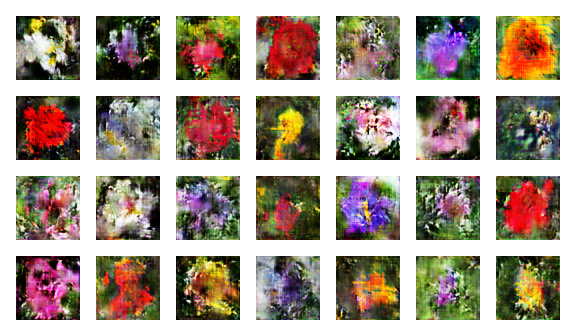

In [ ]:
# 35

import IPython
IPython.display.Image(drive_path +'Project/flowers_data/flowers/output_64_character_extended/train-1.png')

In [ ]:
# 36

test_image("this flower is yellow in color with oval shaped petals",2)

1/1 [==============================] - 0s 102ms/step


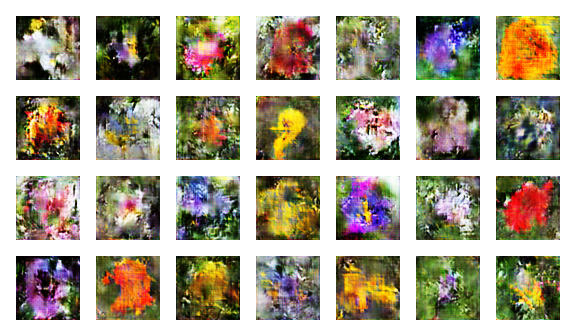

In [ ]:
# 37

import IPython
IPython.display.Image(drive_path +'Project/flowers_data/flowers/output_64_character_extended/train-2.png')

In [ ]:
# 38

test_image("this flower is pink in color with oval shaped petals",3)

1/1 [==============================] - 0s 90ms/step


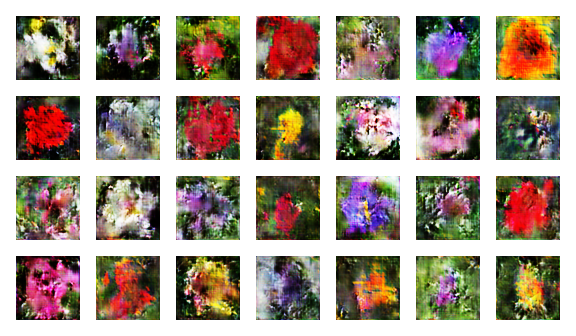

In [ ]:
# 39
import IPython
IPython.display.Image(drive_path +'Project/flowers_data/flowers/output_64_character_extended/train-3.png')

Code Reference:
https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_07_2_Keras_gan.ipynb

https://github.com/utsav-195/text-to-image-generator-gan

Paper Reference:
https://arxiv.org/pdf/1605.05396.pdf